# 第9章 : 拡散モデルの実装

## U-Netの実装

畳み込み、バッチ正規化、ReLUを2回行うConvBlockを作成

In [1]:
import torch
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.convs(x)

UNetを実装する

In [3]:
class UNet(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.down1 = ConvBlock(in_ch, 64)
        self.down2 = ConvBlock(64, 128)
        self.bot1 = ConvBlock(128, 256)
        self.up2 = ConvBlock(128 + 256, 128) # skip connectionがあるから
        self.up1 = ConvBlock(128 + 64, 64)
        self.out = nn.Conv2d(64, in_ch, 1)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    
    def forward(self, x):
        x1 = self.down1(x)
        x = self.maxpool(x1)
        x2 = self.down2(x)
        x = self.maxpool(x2)
        x = self.bot1(x)
        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1) # テンソルの形状:(N, C, H, W)
        x = self.up2(x)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x)
        x = self.out(x)
        return x

UNetの出力の形状確認

In [4]:
model = UNet()
x = torch.randn(10, 1, 28, 28)
y = model(x)
print(y.shape)

torch.Size([10, 1, 28, 28])


## 正弦波位置コーディング
時刻$t$に対して正弦波位置エンコーディングを実装する。`v[0::2]`は、index0を開始地点として2個飛びを表す(0,2,4,..)

In [7]:
import torch

def _pos_encoding(t, output_dim, device="cpu"):
    D = output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device) # [0, 1, ... , D-1]
    div_term = 10000 ** (i / D)

    v[0::2] = torch.sin(t / div_term[0::2]) # 偶数index
    v[1::2] = torch.cos(t / div_term[1::2]) # 奇数index
    
    return v

In [10]:
v = _pos_encoding(1, 16)
print(v.shape)

torch.Size([16])


バッチデータに対する正弦波位置エンコーディングを実装する。

In [8]:
def pos_encoding(ts, output_dim, device="cpu"):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(ts[i], output_dim, device)
    return v

In [9]:
v = pos_encoding(torch.tensor([1, 2, 3]), 16)
print(v.shape) # (3, 16)

torch.Size([3, 16])


UNetの各ConvBlockに正弦波位置エンコーディングした$t$を入力としてうけとり、MLPを通したあとにもとの入力$x$と足し合わせるようにする

In [44]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )
    
    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v) # ブロードキャスト
        return y

In [45]:
class UNet(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
    
    def forward(self, x, timesteps):
        # 正弦波位置エンコーディング
        v = pos_encoding(timesteps, self.time_embed_dim, x.device)
        x1 = self.down1(x, v)
        x = self.maxpool(x1)
        x2 = self.down2(x, v)
        x = self.maxpool(x2)
        
        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v)
        x = self.out(x)
        return x

## 拡散過程
$q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_{t-1}\right) = \mathcal{N} \left(\boldsymbol{x}_t ; \sqrt{1-\beta_t}\boldsymbol{x}_{t-1},\beta_t\boldsymbol{I}\right)$からのサンプルである
$$
\begin{align}
\boldsymbol{\epsilon} &\sim \mathcal{N}\left(\boldsymbol{0}, \boldsymbol{I}\right)\\
\boldsymbol{x}_t &= \sqrt{1-\beta_t}\boldsymbol{x}_{t-1} + \sqrt{\beta_t}\boldsymbol{\epsilon}
\end{align}
$$
をダミーデータで実装する

In [15]:
import torch

x = torch.randn(3 ,64, 64) # ダミーデータ生成
T = 1000
betas = torch.linspace(0.0001, 0.02, T) # 線形ノイズスケジューリング

for t in range(T):
    beta = betas[t]
    eps = torch.randn_like(x) # xと同じ形状のガウスノイズを生成
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

画像に対して拡散過程の実装を行う。

前処理では、`transforms.ToTensor()`を使用する。これは、numpy配列やPILの画像をPyTorchのテンソルに変換すると同時に[0,255]から[0.0, 1.0]にスケーリングして$(H, W, C)$を$(C, H, W)$に変更する

In [17]:
import os
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# 画像の読み込み
file_path = 'flower.png'
image = plt.imread(file_path)
print(image.shape) # 64, 64, 3

# 画像の前処理を定義
preprocess = transforms.ToTensor()
x = preprocess(image)
print(x.shape)

(64, 64, 3)
torch.Size([3, 64, 64])


`transforms.ToTensor()`の逆変換を実装する。生成時に使用する。

In [18]:
def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage()
    return to_pil(x)

実際に拡散過程を実装する。

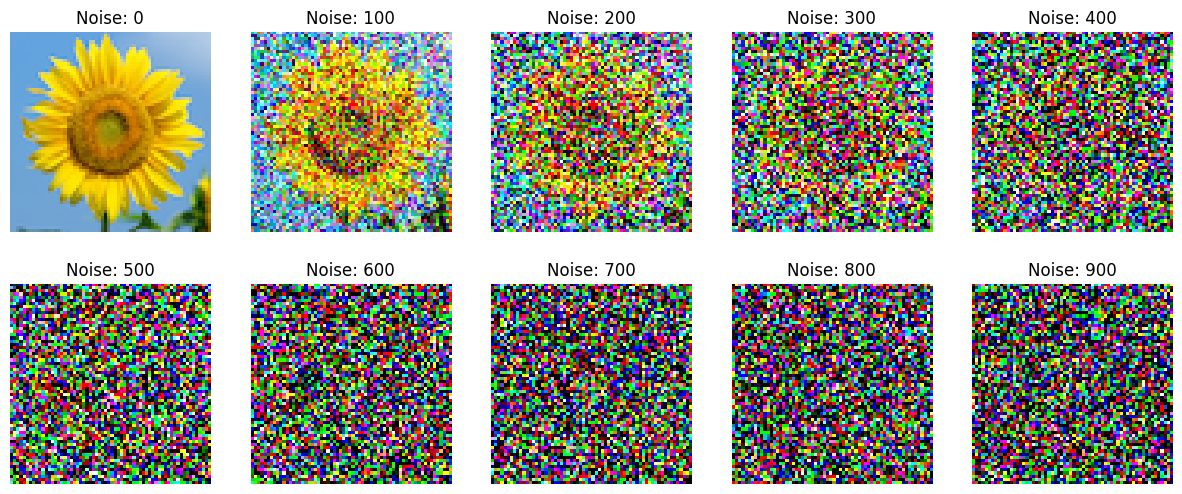

In [19]:
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

for t in range(T):
    if t % 100 == 0:
        img = reverse_to_img(x)
        imgs.append(img)
    
    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

# 10個の画像を2行5列で表示
plt.figure(figsize=(15,6))
for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Noise: {i * 100}')
    plt.axis('off')

plt.show()

$q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_0\right)$からのサンプリングである
$$
\begin{align}
\boldsymbol{\epsilon} &\sim \mathcal{N}\left(\boldsymbol{0}, \boldsymbol{I}\right) \\
\boldsymbol{x}_t &= \sqrt{\bar{\alpha}_t}\boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}
\end{align}
$$
を実装する。

$\bar{\alpha}_t$の実装は`torch.cumprod()`を使う。これは累積積(Cumulative Product)を計算できる

In [23]:
import torch

x = torch.tensor([1, 2, 3, 4])
output = torch.cumprod(x, dim=0)
print(output)

tensor([ 1,  2,  6, 24])


In [24]:
# 画像の読み込み
file_path = "./flower.png"
img = plt.imread(file_path)
x = preprocess(img)

T  = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)

def add_noise(x_0, t, betas):
    T = len(betas)
    assert t >= 1 and t <= T

    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    t_idx = t - 1
    alpha_bar = alpha_bars[t_idx]

    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps

    return x_t

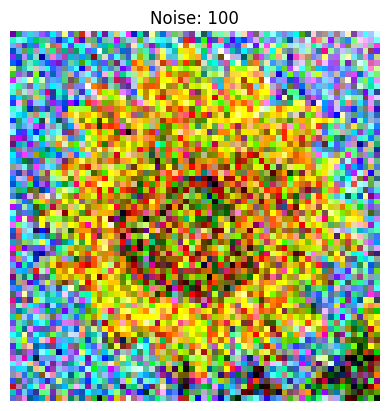

In [25]:
# 例として時刻100のノイズ画像を生成
t = 100
x_t = add_noise(x, t, betas)
# 表示
img = reverse_to_img(x_t)
plt.imshow(img)
plt.title(f'Noise: {t}')
plt.axis('off')
plt.show()

以上の実装をまとめてクラス化する

In [26]:
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cuda'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= self.num_timesteps).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise

        return x_t, noise

## データ生成
8章でやった以下の疑似コードを実装する
1. $\boldsymbol{x}_T \sim \mathcal{N}\left(\boldsymbol{0}, \boldsymbol{I}\right)$
2. $t$を$T$から$1$まで以下を繰り返す
   1. $\boldsymbol{\epsilon} \sim \mathcal{N}\left(\boldsymbol{0}, \boldsymbol{I}\right)$
   2. $t=1$のときは$\boldsymbol{\epsilon}=\boldsymbol{0}$とする
   3. $\sigma_q\left(t\right) = \sqrt{\frac{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t}} $
   4. $\boldsymbol{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(\boldsymbol{x}_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\boldsymbol{\epsilon}_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t\right)\right) + \sigma_q\left(t\right)\boldsymbol{\epsilon}$
3. $\boldsymbol{x}_0$を出力

In [27]:
from tqdm import tqdm # プログレスバーを表示するため

class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cuda'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= self.num_timesteps).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise

        return x_t, noise
    
    # デノイズ処理
    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        # ブロードキャストのため
        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0 # t=1のノイズは0

        mu = (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) /(1 - alpha_bar))
        return mu + noise * std
    
    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t)
        
        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images
        

## 学習
8章でかいた以下の疑似コードを実装していく
 1. $\boldsymbol{x}_0\text{を学習データよりランダムに取得}$
   2. $t\sim U\{1,T\} \quad (\text{一様分布からのサンプリング})$
   3. $\boldsymbol{\epsilon} \sim \mathcal{N}\left(\boldsymbol{0}, \boldsymbol{I}\right)\quad (\text{標準正規分布からのサンプリング})$
   4. $\boldsymbol{x}_t = \sqrt{\bar{\alpha}_t}\boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}}\boldsymbol{\epsilon}\quad (q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_0\right)\text{からのサンプリング})$
   5. $\mathrm{LOSS}\left(\boldsymbol{x}_0;\boldsymbol{\theta}\right) = \| \boldsymbol{\epsilon}_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t\right) - \boldsymbol{\epsilon} \|^2$
   6. $\frac{\partial}{\partial\boldsymbol{\theta}}\mathrm{LOSS}\left(\boldsymbol{x}_0; \boldsymbol{\theta}\right)$を求め勾配法でパラメータを更新

In [46]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off') # 縦軸、横軸を非表示
            i += 1
    plt.show()

preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffuser = Diffuser(num_timesteps, device=device)
model = UNet()
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 201.40it/s]


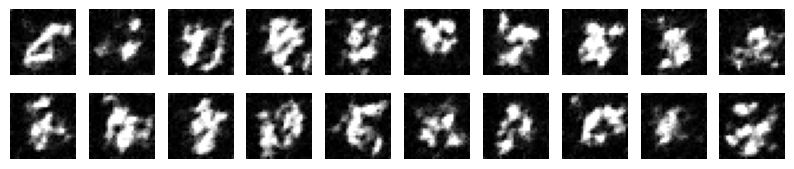

100%|██████████| 469/469 [00:25<00:00, 18.69it/s]


Epoch 0 | Loss: 0.03154915249122104


100%|██████████| 1000/1000 [00:04<00:00, 203.18it/s]


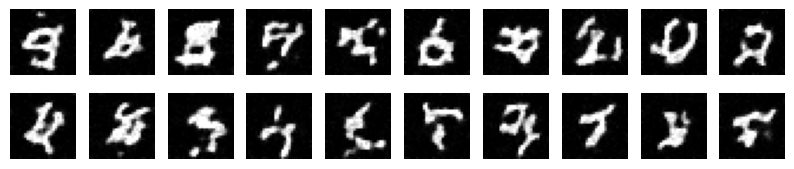

100%|██████████| 469/469 [00:24<00:00, 18.81it/s]


Epoch 1 | Loss: 0.026087954973996574


100%|██████████| 1000/1000 [00:04<00:00, 202.58it/s]


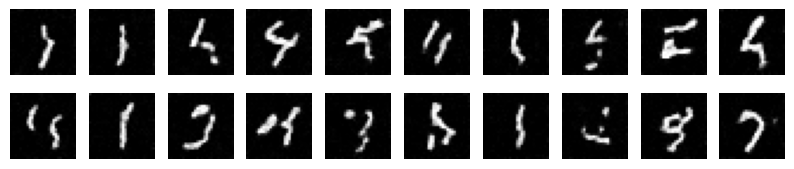

100%|██████████| 469/469 [00:24<00:00, 18.79it/s]


Epoch 2 | Loss: 0.02380825173276574


100%|██████████| 1000/1000 [00:04<00:00, 200.50it/s]


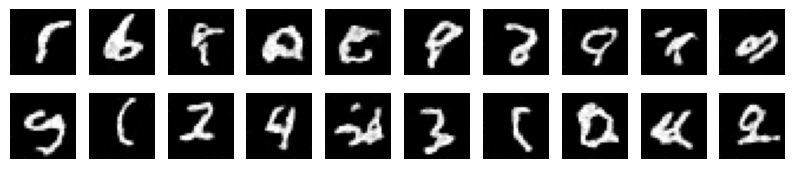

100%|██████████| 469/469 [00:25<00:00, 18.68it/s]


Epoch 3 | Loss: 0.02363449572396876


100%|██████████| 1000/1000 [00:04<00:00, 202.73it/s]


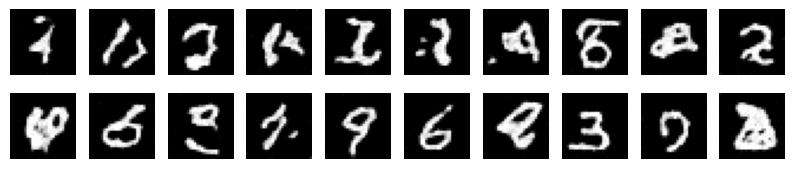

100%|██████████| 469/469 [00:25<00:00, 18.62it/s]


Epoch 4 | Loss: 0.021550270043678883


100%|██████████| 1000/1000 [00:04<00:00, 201.54it/s]


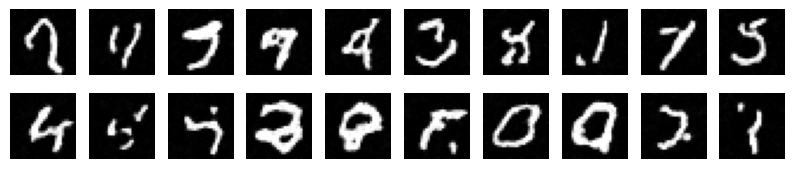

100%|██████████| 469/469 [00:25<00:00, 18.70it/s]


Epoch 5 | Loss: 0.020249174010238923


100%|██████████| 1000/1000 [00:04<00:00, 201.00it/s]


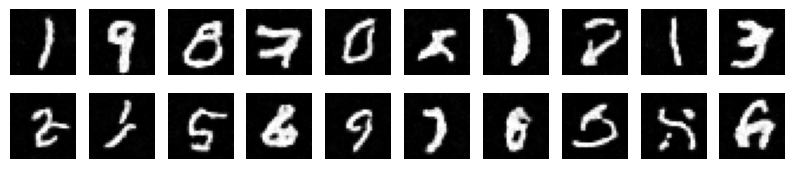

100%|██████████| 469/469 [00:25<00:00, 18.67it/s]


Epoch 6 | Loss: 0.019983521346916267


100%|██████████| 1000/1000 [00:04<00:00, 203.44it/s]


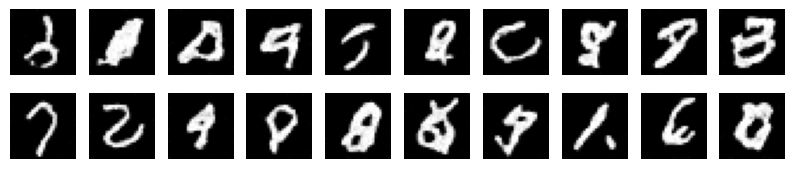

100%|██████████| 469/469 [00:25<00:00, 18.64it/s]


Epoch 7 | Loss: 0.0190098266591872


100%|██████████| 1000/1000 [00:04<00:00, 200.41it/s]


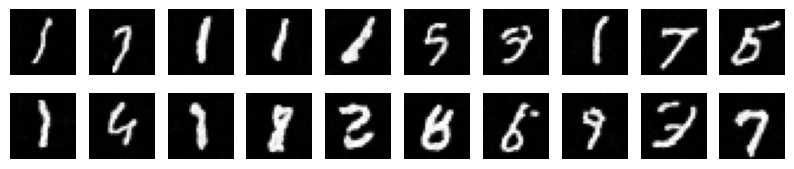

100%|██████████| 469/469 [00:25<00:00, 18.64it/s]


Epoch 8 | Loss: 0.018544070005639277


100%|██████████| 1000/1000 [00:04<00:00, 201.49it/s]


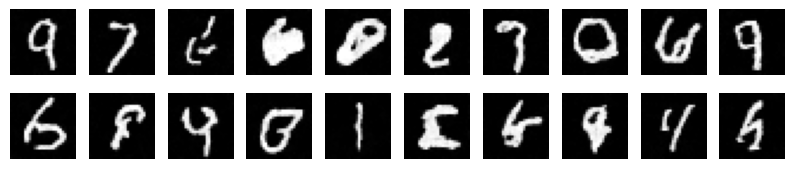

100%|██████████| 469/469 [00:25<00:00, 18.72it/s]


Epoch 9 | Loss: 0.01836271093947801


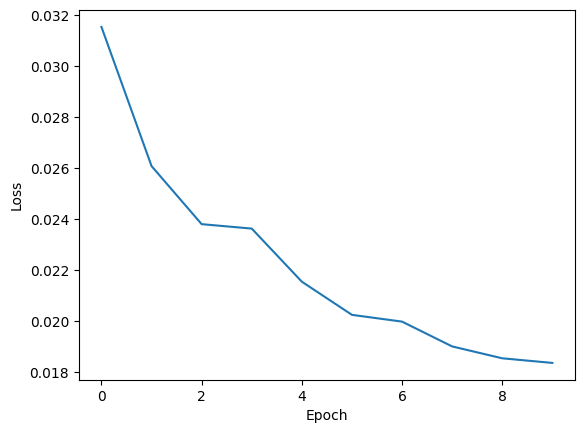

100%|██████████| 1000/1000 [00:04<00:00, 200.26it/s]


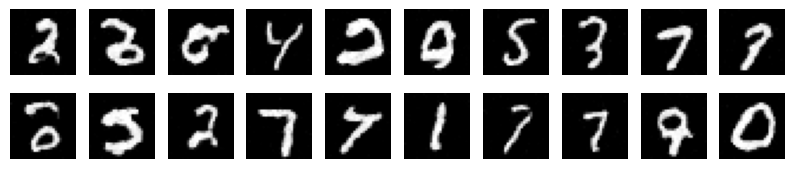

In [48]:
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    # エポックごとにデータ生成して確認
    images = diffuser.sample(model)
    show_images(images)
    
    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device)
        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1
    
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

# 損失のグラフ
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 画像を生成
images = diffuser.sample(model)
show_images(images)